In [49]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Load the data
ultra_marathon_loc = os.path.join(os.getcwd(), 'data', 'ultra_marathon.csv')
# ultra_marathon = pd.read_csv(ultra_marathon_loc, nrows=50000) # Reading 50k rows for faster testing
ultra_marathon = pd.read_csv(ultra_marathon_loc)
ultra_marathon.head(3)


/home/victor/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Year of event,Event dates,Event name,Event distance/length,Event number of finishers,Athlete performance,Athlete club,Athlete country,Athlete year of birth,Athlete gender,Athlete age category,Athlete average speed,Athlete ID
0,2018,06.01.2018,Selva Costera (CHI),50km,22,4:51:39 h,Tnfrc,CHI,1978.0,M,M35,10.286,0
1,2018,06.01.2018,Selva Costera (CHI),50km,22,5:15:45 h,Roberto Echeverría,CHI,1981.0,M,M35,9.501,1
2,2018,06.01.2018,Selva Costera (CHI),50km,22,5:16:44 h,Puro Trail Osorno,CHI,1987.0,M,M23,9.472,2


In [50]:
# Clean the data

# Rename columns
ultra_marathon.rename(columns={
    'Year of event':                'Year',         # int
    'Event dates':                  'Dates',        # [datetime]
    'Event name':                   'Event_name',   # str
    'Event distance/length':        'Length',       # str; contains km or hours
    'Event number of finishers':    'Finishers',    # int
    'Athlete performance':          'Performance',  # str; contains km or hours
    'Athlete club':                 'Club',         # str
    'Athlete country':              'Country',      # str
    'Athlete year of birth':        'Birth',        # float (contains significant nan values)
    'Athlete gender':               'Gender',       # str
    'Athlete age category':         'Age',          # int (contains significant nan values)
    'Athlete average speed':        'Average_speed',# float
    'Athlete ID':                   'Id'            # int
}, inplace=True)
ultra_marathon.insert(4, 'Stages', np.nan)          # int; 0 indicates hours, otherwise number of stages

def parseDates(given_string):
    # The possible formats are: '00.01.2000', '01.-05.01.2000', '31.01.-01.02.2000', '31.12.2000-01.01.2001'
    try:
        return [datetime.strptime(given_string, "%d.%m.%Y")]
    except:
        pass
    try:
        interval = given_string.split('-')
        for separation_length in [3, 6, 10]:
            if len(interval[0]) == separation_length:
                first_day = datetime.strptime(interval[0] + interval[1][separation_length:], "%d.%m.%Y")
                last_day = datetime.strptime(interval[1], "%d.%m.%Y")
                return [first_day + timedelta(days=i) for i in range((last_day - first_day).days + 1)]
    except:
        # None parsable & existent dates such as 00.01.2000
        return None
    

# Returns (int value, int stages), where stage=0 indicates hours and any other stage indicates number of race stages
def parseLengths(given_string):
    if pd.isna(given_string):
        return (np.nan, np.nan)
    
    if "h" in given_string:
        try:
            return(float(re.search(r'(\d+)h', given_string)[1]), 0)
        except AttributeError:
            return (np.nan, np.nan)

    if "mi" in given_string:
        distance = round((1.60934 * float(re.search(r'(\d+(\.\d+)?)mi', given_string)[1])), 2)
    else:
        distance = float(re.search(r'(\d+(\.\d+)?)km', given_string)[1])
    stages = re.search(r'(\d+)Etappen', given_string)

    try:
        if stages == None:
            return (distance, 1)
        else:
            return (distance, int(stages[1]))
    except:
        return (np.nan, np.nan)


# Parse into appropiate data types & remove unnecesary information. Trust me bro
pd.to_numeric(ultra_marathon['Year'], errors='coerce')
ultra_marathon['Dates'] = ultra_marathon['Dates'].apply(parseDates)
# ultra_marathon[['Length', 'Stages']] = ultra_marathon['Length'].apply(parseLengths).apply(pd.Series)
pd.to_numeric(ultra_marathon['Finishers'], errors='coerce')
pd.to_numeric(ultra_marathon['Birth'], errors='coerce')
ultra_marathon['Age'] = ultra_marathon['Age'].str.extract(r'(\d+)')
ultra_marathon['Age'] = pd.to_numeric(ultra_marathon['Age'], errors='coerce', downcast='integer')
ultra_marathon['Average_speed'] = pd.to_numeric(ultra_marathon['Average_speed'], errors='coerce')
ultra_marathon['Id'] = pd.to_numeric(ultra_marathon['Id'], errors='coerce', downcast='integer')

# Recast column types
ultra_marathon['Stages'] = ultra_marathon['Stages'].astype(pd.Int16Dtype())
ultra_marathon['Birth'] = ultra_marathon['Birth'].astype(pd.Int16Dtype())
ultra_marathon['Age'] = ultra_marathon['Age'].astype(pd.Int16Dtype())

# Display information
print(ultra_marathon.info())
print(ultra_marathon.head(3))



# Count how many X values are in gender
print((ultra_marathon['Gender']=='X').sum())

# Eliminate the X and nan values in gender
ultra_marathon = ultra_marathon[ultra_marathon['Gender'].notna() & (ultra_marathon['Gender'] != 'X')]

# Encode gender to 0 and 1
ultra_marathon['Gender'] = ultra_marathon['Gender'].map({'M': 0, 'F': 1})


# Drop all entries with null values, except for the 'Club' column (and maybe birth, age)
# ultra_marathon.dropna(inplace=True)


# Useful commands
# print(ultra_marathon['Id'].unique()[:150])
# print(ultra_marathon['Id'].isna().sum())
# print(ultra_marathon.isnull().sum())
# print(ultra_marathon[ultra_marathon['Finishers'] =="0"].sum())
# null_values = ultra_marathon[ultra_marathon['Event_name'].isnull() | (ultra_marathon['Event_name'] == '') | (ultra_marathon['Event_name'] == 'NULL') | (ultra_marathon['Event_name'] == 'NA')]






<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7461195 entries, 0 to 7461194
Data columns (total 14 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Year           int64  
 1   Dates          object 
 2   Event_name     object 
 3   Length         object 
 4   Stages         Int16  
 5   Finishers      int64  
 6   Performance    object 
 7   Club           object 
 8   Country        object 
 9   Birth          Int16  
 10  Gender         object 
 11  Age            Int16  
 12  Average_speed  float64
 13  Id             int32  
dtypes: Int16(3), float64(1), int32(1), int64(2), object(7)
memory usage: 661.7+ MB
None
   Year                  Dates           Event_name Length  Stages  Finishers  \
0  2018  [2018-01-06 00:00:00]  Selva Costera (CHI)   50km    <NA>         22   
1  2018  [2018-01-06 00:00:00]  Selva Costera (CHI)   50km    <NA>         22   
2  2018  [2018-01-06 00:00:00]  Selva Costera (CHI)   50km    <NA>         22   

  Performance            

In [51]:
# Data exploration

print(ultra_marathon.info())

# Summary statistics
print(ultra_marathon.describe(include='all')) # include='all' includes non-numeric columns

# print unique values for categorical columns
print('Event name:', ultra_marathon['Event_name'].unique())
print('Length:', ultra_marathon['Length'].unique())
print('Club:', ultra_marathon['Club'].unique())
print('Country:', ultra_marathon['Country'].unique())
print('Gender:', ultra_marathon['Gender'].unique())

1798 1
2019 848630144
Year
1790             1
1800            14
1830             1
1860             3
1870          2549
1880          1848
1890         18722
1900          4354
1910           460
1920          9707
1930         10513
1940          2951
1950         38830
1960       5017646
1970     120464530
1980     911094499
1990    1829216787
2000    2236312555
2010    5364378767
2020     366836596
Name: Finishers, dtype: int64
Year
2011    295579892
2012    390043222
2013    392429721
2014    482431965
2015    561900781
2016    615397625
2017    650396578
2018    734902250
2019    848630144
2020     59297025
2021    123090729
2022    184448842
Name: Finishers, dtype: int64


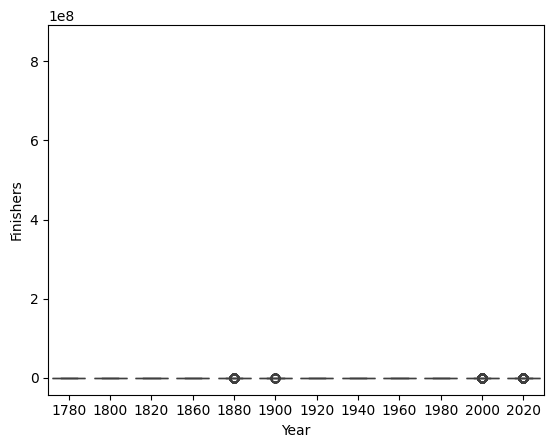

In [ ]:
# Graphs to explore the data

# analyze how many finisher there are per year
finishers_per_year = ultra_marathon.groupby('Year')['Finishers'].sum()
sns.lineplot(x=finishers_per_year.index, y=finishers_per_year.values)
# print the minimum and maximum number of finishers
print(finishers_per_year.idxmin(), finishers_per_year.min())
# print the year with the maximum number of finishers
print(finishers_per_year.idxmax(), finishers_per_year.max())
# see the outliers using a boxplot (x-axis is the year (by decade) and y-axis is the number of finishers)
sns.boxplot(x=ultra_marathon['Year']//20*20, y=ultra_marathon['Finishers'])
# print number of finisher per decade
print(ultra_marathon.groupby(ultra_marathon['Year']//10*10)['Finishers'].sum())
# print number of finisher for the last decade (year by year)
print(ultra_marathon[ultra_marathon['Year'] > 2010].groupby('Year')['Finishers'].sum())

Decade  Gender
1790    0         100.000000
1800    0         100.000000
1830    0         100.000000
1860    0         100.000000
1870    0          92.549020
        1           7.450980
1880    0          97.641509
        1           2.358491
1890    0          99.038462
        1           0.961538
1900    0         100.000000
1910    0         100.000000
1920    0          99.730458
        1           0.269542
1930    0          98.823529
        1           1.176471
1940    0         100.000000
1950    0         100.000000
1960    0          98.673740
        1           1.326260
1970    0          97.228681
        1           2.771319
1980    0          93.900671
        1           6.099329
1990    0          87.511016
        1          12.488984
2000    0          82.693220
        1          17.306780
2010    0          79.522259
        1          20.477741
2020    0          77.077873
        1          22.922127
dtype: float64


<Figure size 1000x600 with 0 Axes>

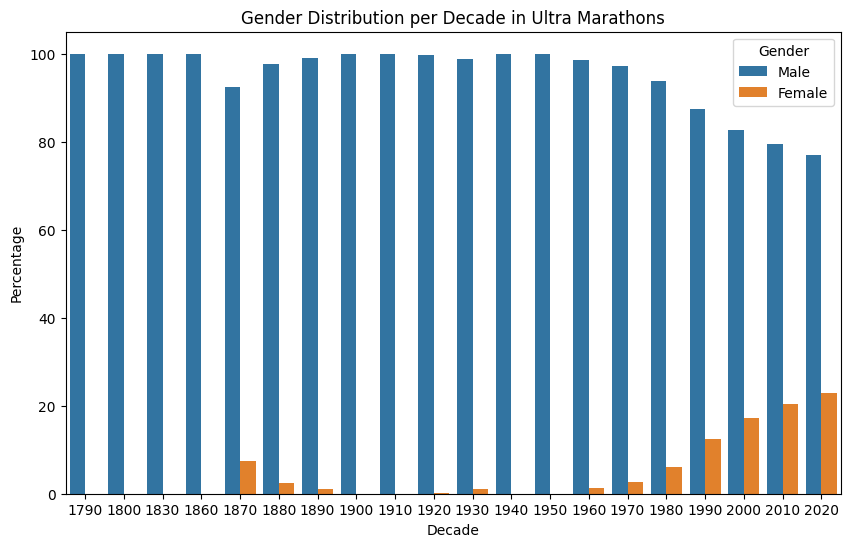

In [ ]:
# Explore the gender distribution in the dataset

# Create a copy of the ultra_marathon DataFrame
ultra_marathon_copy = ultra_marathon.copy()

# Extract the decade from the 'Year' column
ultra_marathon_copy['Decade'] = ultra_marathon_copy['Year'] // 10 * 10

# Group by decade and gender, and count the number of occurrences
gender_distribution = ultra_marathon_copy.groupby(['Decade', 'Gender']).size()

# Calculate the total number of occurrences per decade
total_per_decade = gender_distribution.groupby('Decade').sum()

# Calculate the percentage of each gender per decade
percentage_per_decade = gender_distribution / total_per_decade * 100

# To print the gender distribution per decade as a percentage
print(percentage_per_decade)

# Preparing data for plotting
# Reset index to convert the Series into a DataFrame
percentage_df = percentage_per_decade.reset_index(name='Percentage')

# Plotting
# Now we plot 'Percentage' against 'Decade' with 'Gender' as the hue.
plt.figure(figsize=(10, 6)) 
# Replace 0 with 'Male' and 1 with 'Female' in the 'Gender' column of percentage_df for better visualization
percentage_df['Gender'] = percentage_df['Gender'].replace({0: 'Male', 1: 'Female'})

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=percentage_df, x='Decade', y='Percentage', hue='Gender')
plt.title('Gender Distribution per Decade in Ultra Marathons')
plt.ylabel('Percentage')
plt.xlabel('Decade')
plt.show()



Club
*Tokyo             10192
*La Réunion         8994
*Kanagawa Pref.     5902
*Paris              5482
*Osaka Pref.        4865
*CA                 4437
Rand AC             4243
*Saitama Pref.      4101
*Aichi Pref.        3963
*Fukuoka Pref.      3459
Name: count, dtype: int64


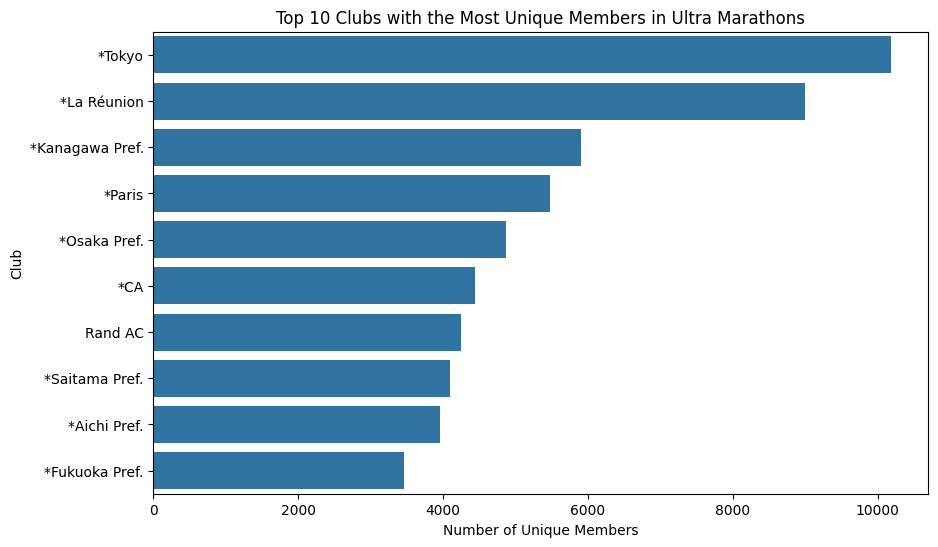

In [ ]:
# Explore the clubs in the dataset

# Create a copy of the ultra_marathon DataFrame
ultra_marathon_copy = ultra_marathon.copy()

# Drop rows with missing values in the 'Club' column
ultra_marathon_copy.dropna(subset=['Club'], inplace=True)

# Drop duplicates to ensure each member is only counted once per club
unique_members_per_club = ultra_marathon_copy.drop_duplicates(subset=['Id', 'Club'])

# Now, count the occurrences (which represent unique members now) of each club
unique_club_distribution = unique_members_per_club['Club'].value_counts()

# Print the top 10 clubs with the most unique members
print(unique_club_distribution.head(10))

# Plot the top 10 clubs with the most unique members
plt.figure(figsize=(10, 6))
sns.barplot(x=unique_club_distribution.head(10).values, y=unique_club_distribution.head(10).index)
plt.title('Top 10 Clubs with the Most Unique Members in Ultra Marathons')
plt.xlabel('Number of Unique Members')
plt.ylabel('Club')
plt.show()

Event_name
Two Oceans Marathon (RSA)                     263574
Comrades Marathon - Down Run (RSA)            224491
Comrades Marathon - Up Run (RSA)              221162
100 km Lauf Biel (SUI)                        100657
Two Oceans Marathon - 50km Split (RSA)         84737
GutsMuths-Rennsteiglauf (GER)                  80233
100 km del Passatore, Firenze-Faenza (ITA)     55598
Les 100 km de Millau (FRA)                     42630
Yukihashi to Beppu 100 km (JPN)                36636
Om Die Dam 50km (RSA)                          32456
Name: count, dtype: int64


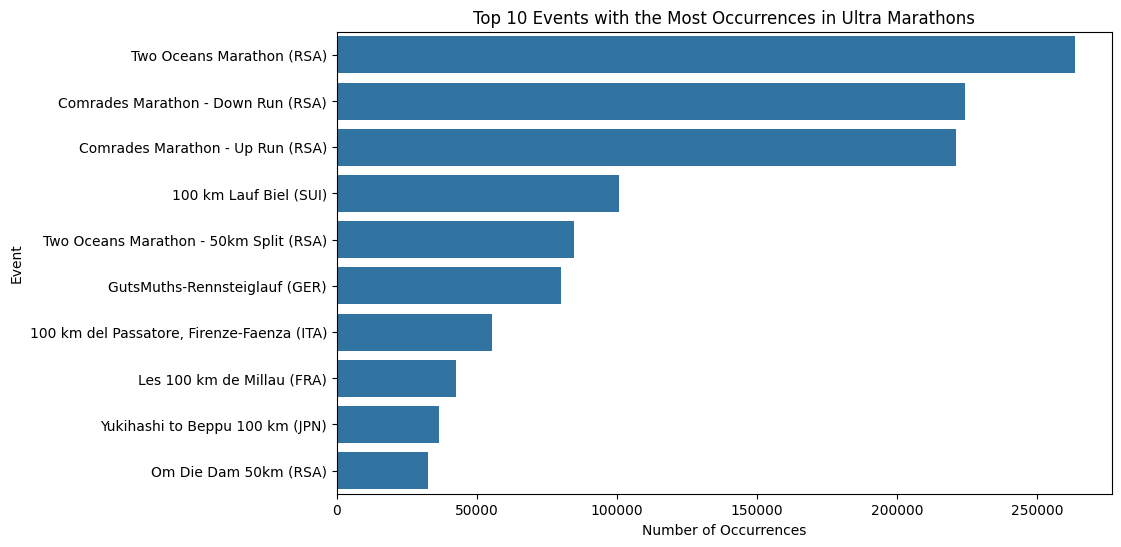

In [ ]:
# Explore the most popular events in the dataset

# Create a copy of the ultra_marathon DataFrame
ultra_marathon_copy = ultra_marathon.copy()

# Group by 'Event_name' and count the number of occurrences
event_distribution = ultra_marathon_copy['Event_name'].value_counts()

# Print the top 10 events with the most participants
print(event_distribution.head(10))

# Plot the top 10 events with the most occurrences and the year of the event
plt.figure(figsize=(10, 6))
sns.barplot(x=event_distribution.head(10).values, y=event_distribution.head(10).index)
plt.title('Top 10 Events with the Most Occurrences in Ultra Marathons')
plt.xlabel('Number of Occurrences')
plt.ylabel('Event')
plt.show()


Country
USA    1389925
FRA    1170882
RSA     877630
JPN     603132
GER     442056
GBR     347143
ITA     344076
ESP     232311
CHN     219944
AUS     150761
Name: count, dtype: int64


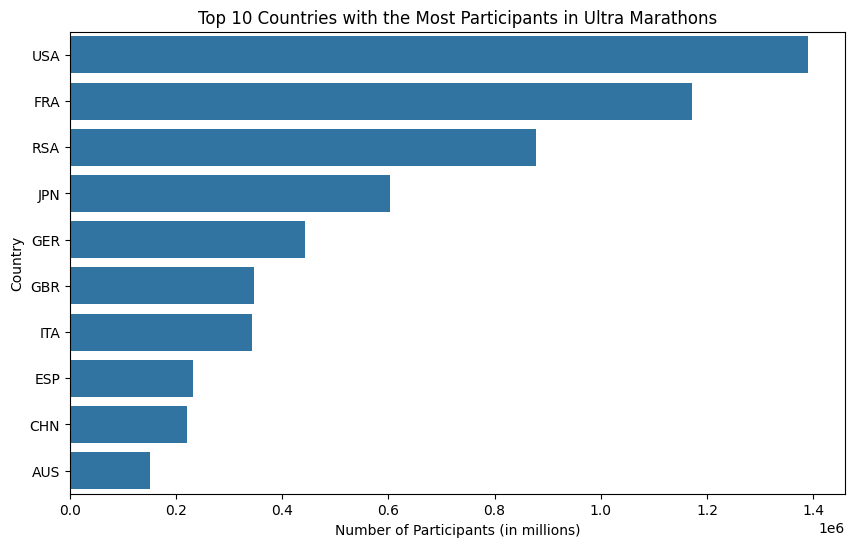

In [ ]:
# Explore the countries with the most participants in the dataset

# Create a copy of the ultra_marathon DataFrame
ultra_marathon_copy = ultra_marathon.copy()

# Group by 'Country' and count the number of occurrences
country_distribution = ultra_marathon_copy['Country'].value_counts()

# Print the top 10 countries with the most participants
print(country_distribution.head(10))

# Plot the top 10 countries with the most participants
plt.figure(figsize=(10, 6))
sns.barplot(x=country_distribution.head(10).values, y=country_distribution.head(10).index)
plt.title('Top 10 Countries with the Most Participants in Ultra Marathons')
plt.xlabel('Number of Participants')
plt.ylabel('Country')
plt.show()

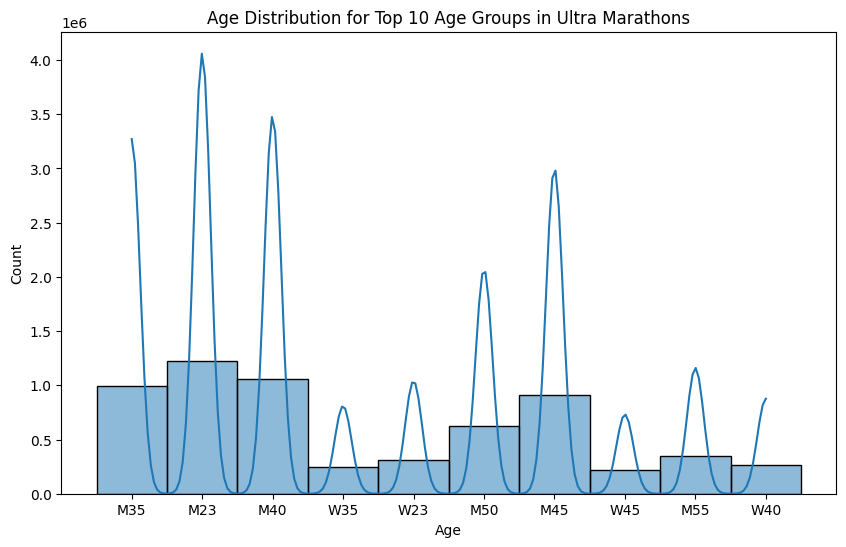

In [ ]:
# Explore the age distribution in the dataset

# Create a copy of the ultra_marathon DataFrame
ultra_marathon_copy = ultra_marathon.copy()

# Drop rows with missing values in the 'Age' column
ultra_marathon_copy.dropna(subset=['Age'], inplace=True)

# Get the top 10 age groups
top_10_age_groups = ultra_marathon_copy['Age'].value_counts().head(10).index

# Filter the DataFrame for the top 10 age groups
ultra_marathon_top_10_age = ultra_marathon_copy[ultra_marathon_copy['Age'].isin(top_10_age_groups)]

# Plot the age distribution for the top 10 age groups
plt.figure(figsize=(10, 6))
sns.histplot(ultra_marathon_top_10_age['Age'], kde=True)
plt.title('Age Distribution for Top 10 Age Groups in Ultra Marathons')
plt.xlabel('Age')
plt.ylabel('Count')

plt.show()
                                           